# MNIST

FC network on the MNIST dataset

# Guided exercise


- The code will run but the network will not train: we will read carefully the code together
and try to figure out where the problem is.

Then you should (we will do it together anyway...)

- Run it and plot training and test loss and error

- Experiment a bit with changing the hidden layer size

- Define a new network with two hidden layers of sizes [50,30] 
and train it for a few epochs

- Write a function to extract representations in both hidden layers

- Change loss function by adding a L2 regularization (see documentation and the implementation of 
    optim.SGD)
  can you make sense of what exactly happens there? This is also key if you want to modify the learning
  rule by yourself, be it applying L1 regularization or define some fancier learning rules.
  On may want, for example, to *block* learning of just one parameter or a group of parameters, but
  not all the parameters of a *group*, like all the parameters in a layer.
  This could be only done (to my knowledge) by customized manipulations such as for example
  *masking*, we will discuss it for the exam.
  
- Make a T-SNE 2D visualization of the representations in the two
hidden layers with $N=1000$ test samples. (Solution: you may want to define a new
loader (custom_loader) for this purpose, and once you have it you may need to sample from it
sample = next(iter(custom_loader)))
)


Now, for the rest of this day, you can experiment by yourself or retrace some of our passages.
You don't have to submit anything, just try whatever you want.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [3]:
class FCNet(nn.Module):
    def __init__(self,din=784, dh=30, dout=10):
        super(FCNet, self).__init__()
        
        self.lin1 = nn.Linear(din, dh)
        self.lin2 = nn.Linear(dh, dout)
    
    def forward(self, x):    
        x = torch.sigmoid(self.lin1(x)) 
        return  F.log_softmax(self.lin2(x))  


In [4]:
# Add another hidden layer
class DeeperFCNet(nn.Module):
    def __init__(self,din=784, dh1=50, dh2=30, dout=10):
        super(DeeperFCNet, self).__init__()
        
        self.lin1 = nn.Linear(din, dh1)
        
        self.lin2 = nn.Linear(dh1, dh2)
        
        self.lin3 = nn.Linear(dh2, dout)
    
    def forward(self, x):
        
        x = torch.sigmoid(self.lin1(x))
        
        x = torch.sigmoid(self.lin2(x))
        
        return  F.log_softmax(self.lin3(x), dim=1)  
    
    
    def extract(self, x):
        
        h1 = torch.sigmoid(self.lin1(x))
        
        h2 = torch.sigmoid(self.lin2(h1))
        
        return h1, h2
        

Questions:
- is this a *deep* network?
- how many hidden layers do we have?
- what is the number of parameters?
- how to you forward pass an input data?

In [5]:
F.nll_loss?

Signature:
F.nll_loss(
    input,
    target,
    weight=None,
    size_average=None,
    ignore_index=-100,
    reduce=None,
    reduction='mean',
)
Docstring:
The negative log likelihood loss.

See :class:`~torch.nn.NLLLoss` for details.

Args:
    input: :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
        in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K \geq 1`
        in the case of K-dimensional loss.
    target: :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
        or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
        K-dimensional loss.
    weight (Tensor, optional): a manual rescaling weight given to each
        class. If given, has to be a Tensor of size `C`
    size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
        the losses are averaged over each loss element in the batch. Note that for
        some losses, there multiple elements per sample. If the

[o1,o2,....o10]

max is o2 ---> "1"
y == 1 'hit'
otherwise 'miss'

n.of hits/n.of samples = accuracy

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1,784)
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.nll_loss(output, target)
        
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        

In [7]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1,784)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
# Training settings
input_size=(784,)
batch_size=64
test_batch_size=1000
epochs=10
lr=0.01
momentum=0.0   
seed=1
log_interval=100

In [9]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [10]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)

In [11]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

In [12]:
model = FCNet().to(device)

In [13]:
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]          23,550
            Linear-2                   [-1, 10]             310
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


/home/martina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [14]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [15]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

/home/martina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300056
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.086020
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.915595
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.829770
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.647874
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.458466
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.429202
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.302658
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.175045
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.143153

Test set: Average loss: 1.1293, Accuracy: 8024/10000 (80%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.173451
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.101333
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.907203
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.999891
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.949019
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.937695
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.821586
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.866027
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.657972
T

# Deeper net

In [16]:
model3 = DeeperFCNet().to(device)

In [17]:
optimizer3 = optim.SGD(model3.parameters(), lr=lr, momentum=momentum)

In [18]:
for epoch in range(1, epochs + 1):
    train(model3, device, train_loader, optimizer3, epoch)
    test(model3, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291912
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.298840
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.308768
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.279930
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.283123
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.273269
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.253836
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.260078
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.255423
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.256201

Test set: Average loss: 2.2337, Accuracy: 3629/10000 (36%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.229446
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.210552
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.208615
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.169799
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.183822
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.128182
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.143588
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.139709
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.104643
T

In [19]:
sample = next(iter(test_loader))[0].view(-1, 784)

In [20]:
sample.shape

torch.Size([1000, 784])

In [21]:
r1, r2 = model3.extract(sample)

In [22]:
print(r1,r2)

tensor([[0.9876, 0.1186, 0.5038,  ..., 0.9928, 0.8653, 0.9943],
        [0.4747, 0.9309, 0.8093,  ..., 0.3971, 0.2847, 0.8456],
        [0.9764, 0.9787, 0.9045,  ..., 0.2225, 0.0378, 0.1355],
        ...,
        [0.8427, 0.3655, 0.7764,  ..., 0.9984, 0.8792, 0.9982],
        [0.6864, 0.9950, 0.9870,  ..., 0.6522, 0.0763, 0.8377],
        [0.0154, 0.0080, 0.9814,  ..., 0.0152, 0.0046, 0.0045]],
       grad_fn=<SigmoidBackward>) tensor([[0.9626, 0.3312, 0.4722,  ..., 0.1003, 0.4627, 0.8755],
        [0.0610, 0.7652, 0.2919,  ..., 0.9704, 0.3671, 0.1261],
        [0.1907, 0.7593, 0.6767,  ..., 0.8188, 0.7372, 0.1453],
        ...,
        [0.8939, 0.4285, 0.2371,  ..., 0.5358, 0.2327, 0.8294],
        [0.1463, 0.8762, 0.3857,  ..., 0.9541, 0.3199, 0.2446],
        [0.9717, 0.6905, 0.8413,  ..., 0.0686, 0.1343, 0.9310]],
       grad_fn=<SigmoidBackward>)


In [23]:
print(r1.shape)

torch.Size([1000, 50])


In [24]:
r1 = r1.detach().numpy()
r2 = r2.detach().numpy()

In [25]:
#h1 = h1.detach().numpy()
#h2 = h2.detach().numpy()

In [26]:
e1 = TSNE(n_components=2).fit_transform(r1)
e2 = TSNE(n_components=2).fit_transform(r2)

In [27]:
e1.shape

(1000, 2)

In [28]:
r1.shape

(1000, 50)

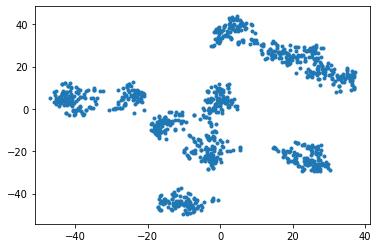

In [29]:
plt.plot(e1[:,0],e1[:,1], '.')

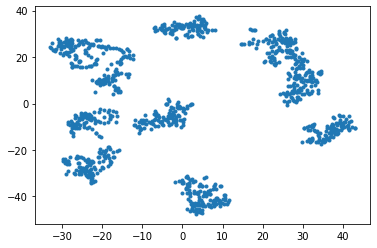

In [30]:
plt.plot(e2[:,0],e2[:,1], '.')

In [31]:
# Density peak clustering

x -> h1 -> h2 -....-> 

In [32]:
out = model3(sample)

In [33]:
out = out.detach().numpy()

In [34]:
e3 = TSNE(n_components=2).fit_transform(out)

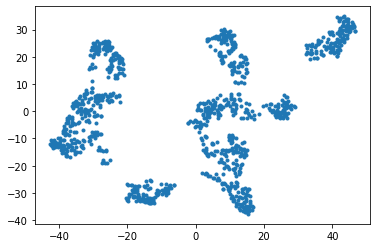

In [35]:
plt.plot(e3[:,0],e3[:,1], '.')

$\theta$ = $\theta$ - $\alpha$ ( grad L + $\lambda$ $\theta$) 

In [36]:
optim.SGD??

Init signature:
optim.SGD(
    params,
    lr=<required parameter>,
    momentum=0,
    dampening=0,
    weight_decay=0,
    nesterov=False,
)
Source:        
class SGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), targ

In [37]:
model4 = DeeperFCNet().to(device)

In [38]:
#We change the option of the optimizer to add the L2 regularization
optimizer4 = optim.SGD(model4.parameters(), lr=lr, momentum=momentum,  weight_decay=0.5)

In [39]:
for epoch in range(1, epochs + 1):
    train(model4, device, train_loader, optimizer4, epoch)
    test(model4, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331374
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.295485
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.301369
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.308304
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.302582
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.301656
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.296278
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.302168
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.302034
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.297843

Test set: Average loss: 2.3014, Accuracy: 1135/10000 (11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.302462
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.296545
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.293572
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.306719
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.298751
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.306308
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.302468
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.302160
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.303361
T

In [40]:
r1_L2_largeWD, r2_L2_largeWD = model4.extract(sample)

In [41]:
r1

array([[0.9875858 , 0.11856472, 0.50376034, ..., 0.9927608 , 0.8652809 ,
        0.9942952 ],
       [0.4746984 , 0.9309091 , 0.80933577, ..., 0.39708838, 0.28470856,
        0.84556323],
       [0.97635037, 0.9786879 , 0.9045155 , ..., 0.22254446, 0.03783028,
        0.13546455],
       ...,
       [0.8427042 , 0.36552444, 0.7763864 , ..., 0.99836344, 0.87921494,
        0.99824655],
       [0.6864034 , 0.99495244, 0.9869688 , ..., 0.6521605 , 0.07633646,
        0.8376905 ],
       [0.01544651, 0.00801038, 0.981441  , ..., 0.01517022, 0.00455188,
        0.00446592]], dtype=float32)

In [42]:
r1_L2_largeWD

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
       grad_fn=<SigmoidBackward>)

In [44]:
r1_L2_largeWD = r1_L2_largeWD.detach().numpy()
r2_L2_largeWD = r2_L2_largeWD.detach().numpy()

In [45]:
e1_L2_largeWD = TSNE(n_components=2).fit_transform(r1_L2_largeWD)
e2_L2_largeWD = TSNE(n_components=2).fit_transform(r2_L2_largeWD)

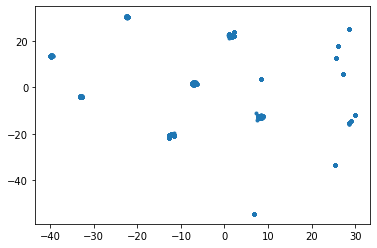

In [54]:
plt.plot(e1_L2_largeWD[:,0],e1_L2_largeWD[:,1], '.')

In [46]:
model5 = DeeperFCNet().to(device)

In [47]:
#Smaller weight_decay
optimizer5 = optim.SGD(model5.parameters(), lr=lr, momentum=momentum,  weight_decay=0.0001)

In [48]:
for epoch in range(1, epochs + 1):
    train(model5, device, train_loader, optimizer5, epoch)
    test(model5, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.429528
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.338742
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.290154
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.293868
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.298368
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.262805
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.257061
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.268010
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.263597
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.254347

Test set: Average loss: 2.2428, Accuracy: 3180/10000 (32%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.234122
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.234684
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.249715
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.209418
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.205406
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.188012
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.154447
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.155865
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.117585
T

In [49]:
r1_L2_smallWD, r2_L2_smallWD = model5.extract(sample)

In [50]:
r1

array([[0.9875858 , 0.11856472, 0.50376034, ..., 0.9927608 , 0.8652809 ,
        0.9942952 ],
       [0.4746984 , 0.9309091 , 0.80933577, ..., 0.39708838, 0.28470856,
        0.84556323],
       [0.97635037, 0.9786879 , 0.9045155 , ..., 0.22254446, 0.03783028,
        0.13546455],
       ...,
       [0.8427042 , 0.36552444, 0.7763864 , ..., 0.99836344, 0.87921494,
        0.99824655],
       [0.6864034 , 0.99495244, 0.9869688 , ..., 0.6521605 , 0.07633646,
        0.8376905 ],
       [0.01544651, 0.00801038, 0.981441  , ..., 0.01517022, 0.00455188,
        0.00446592]], dtype=float32)

In [51]:
r1_L2_smallWD

tensor([[0.0937, 0.9993, 0.0554,  ..., 0.9986, 0.8133, 0.9980],
        [0.7274, 0.1395, 0.8733,  ..., 0.2082, 0.8641, 0.2000],
        [0.9317, 0.9693, 0.9311,  ..., 0.8789, 0.9045, 0.8474],
        ...,
        [0.0622, 0.9754, 0.4325,  ..., 0.9731, 0.7457, 0.9435],
        [0.8849, 0.7877, 0.9850,  ..., 0.2332, 0.9189, 0.3180],
        [0.9990, 0.9998, 0.9958,  ..., 0.0074, 0.0109, 0.9996]],
       grad_fn=<SigmoidBackward>)

In [52]:
r1_L2_smallWD = r1_L2_smallWD.detach().numpy()
r2_L2_smallWD = r2_L2_smallWD.detach().numpy()

In [53]:
e1_L2_smallWD = TSNE(n_components=2).fit_transform(r1_L2_smallWD)
e2_L2_smallWD = TSNE(n_components=2).fit_transform(r2_L2_smallWD)

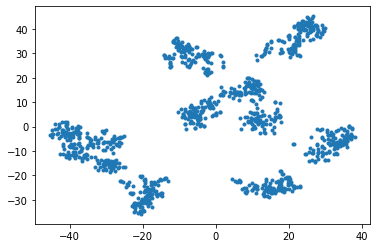

In [55]:
plt.plot(e1_L2_smallWD[:,0],e1_L2_smallWD[:,1], '.')